In [1]:
import pandas as pd
import numpy as np
import phunk
from sbpy import photometry as phot
import numpy as np
import lmfit
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import stats
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [2]:
def read_excel(path, excel_file, sheet_name = "T08oa"):
    # Read the specified sheet into a DataFrame
    df = pd.read_excel(path + excel_file, sheet_name=sheet_name)
    df.sort_values('Ph')
    df['magred'] = pd.to_numeric(df['magred'], errors='coerce')  # Convert to numeric, NaN for invalid values
    df['Ph'] = pd.to_numeric(df['Ph'], errors='coerce')          # Convert to numeric, NaN for invalid values
    df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce')

    
    # Extract the columns and convert them to NumPy arrays
    real_mag = np.array(df['magred']) + 0.32  # Correction from the Red filter
    real_mag = real_mag - 0.08 # Korekcija observatorijai
    ph = df['Ph'].to_numpy(dtype = np.float64)
    epoch = df['epoch'].to_numpy(dtype = float)
    band = ["R"]*len(epoch)
    return real_mag, ph, epoch, band

In [3]:
def outlier_remover(df):
    epochs = np.array([int(x) for x in df[2]])
    epochs_set = list(set(epochs))
    remove_idx = []
    for epoch in epochs_set:
        idx = np.where(epochs == epoch)
        temp_ep_list = np.array(df[0][idx], dtype = np.float64)
        z = np.abs(stats.zscore(temp_ep_list))

        threshold_z = 2

        outlier_indices = np.where(z > threshold_z)
        # Back to original
        outlier_indices = idx[0][np.array(outlier_indices)]

        if outlier_indices != None:
            remove_idx.append(outlier_indices)
    print (remove_idx)
    remove_idx = np.array(remove_idx).flatten()
    
    df = np.delete(df, remove_idx, axis = 1)
    return df
        #print (outlier_indices)

In [4]:
def outlier_remover_total(df, contamination = 0.01, n_estimators = 200):
    real_mag, ph, epoch, band = df
    
    X = np.column_stack((ph, real_mag, epoch))

    scaler = StandardScaler()

    # Create an Isolation Forest model
    iso_forest = IsolationForest(max_samples="auto", random_state=0,contamination=contamination, n_estimators = n_estimators) # Adjust contamination based on your dataset
    # Fit the model to your data
    X = np.column_stack((ph, real_mag, epoch))

    X_scaled = scaler.fit_transform(X)

    iso_forest.fit(X_scaled)
    # Predict outliers
    outliers = iso_forest.predict(X_scaled)  == -1 
    # Keep the ones with the phase below 5, as it usually discards them due to non-linear behaviour
    idx_keep = np.where(ph <= 5)[0]
    outliers[idx_keep] = False
    
    plt.scatter(X[:,0], X[:,1], label = "data")
    plt.scatter(X[:,0][outliers], X[:,1][outliers], c = "red", alpha = 0.8, label = "removed", marker = "x")
    plt.xlabel("Phase")
    plt.ylabel("Reduced mag")
    plt.legend()
    ax = plt.gca()
    ax.invert_yaxis()

    plt.show()
    return real_mag[~outliers], ph[~outliers], epoch[~outliers]

In [5]:
def eval_fit_HG(phase, H, G):
    """Evaluation function for fitting. Required for lmfit."""
    return phot.HG.evaluate(np.radians(phase), H, G)
def eval_fit_HG1G2(phase, H, G1, G2):
    """Evaluation function for fitting. Required for lmfit."""
    return phot.HG1G2.evaluate(np.radians(phase), H, G1, G2)

import lmfit
import numpy as np

def fit(phase, mag, weights=None, method="HG", mag_errors=None):
    """
    Fit a phase curve using the HG or HG1G2 model with constraints.

    Parameters:
    - phase (array-like): Phase angles.
    - mag (array-like): Observed magnitudes.
    - weights (array-like, optional): Weights for fitting. Defaults to 1/mag_errors.
    - method (str): Phase function model to use ("HG" or "HG1G2").
    - mag_errors (array-like, optional): Magnitude uncertainties. Defaults to 0.03 for all data points.

    Returns:
    - result: Fitting result object from lmfit.
    """
    # Select the appropriate model
    if method == "HG":
        model = lmfit.Model(eval_fit_HG)
    elif method == "HG1G2":
        model = lmfit.Model(eval_fit_HG1G2)
    else:
        raise ValueError("Invalid method. Use 'HG' or 'HG1G2'.")

    # Initialize parameters
    params = lmfit.Parameters()
    params.add("H", value=15, min=0, max=30)

    if method == "HG":
        params.add("G", value=0.15, min=0, max=1.0)
    elif method == "HG1G2":
        params.add("G1", value=0.15, min=0, max=1.0)  # Free parameter
        params.add("G2", value = 0.2, min=0, max = 1.0)        # Dependent parameter ensuring G1 + G2 <= 1

    # Set default magnitude errors if not provided
    if mag_errors is None:
        mag_errors = np.full(len(phase), 0.03)

    # Default weights if not provided
    if weights is None:
        weights = 1.0 / mag_errors

    # Perform the fit
    result = model.fit(
        mag,
        params,
        phase=phase,
        method="least_squares",
        weights=weights,
        fit_kws={"loss": "soft_l1"},
    )

    return result


In [6]:
def hg_phase_function(H, G, alpha):
    """
    Calculate the apparent magnitude V of an asteroid at phase angle alpha
    using the HG phase function.

    Parameters:
    - H (float): Absolute magnitude of the asteroid.
    - G (float): Slope parameter of the asteroid (0 ≤ G ≤ 1).
    - alpha (float or array-like): Phase angle(s) in degrees.

    Returns:
    - V (float or array-like): Apparent magnitude(s) at phase angle(s) alpha.
    """
    # Convert alpha to radians
    alpha_rad = np.radians(alpha)

    # Compute Phi1 and Phi2
    phi1 = np.exp(-3.33 * np.power(np.tan(alpha_rad / 2), 0.63))
    phi2 = np.exp(-1.87 * np.power(np.tan(alpha_rad / 2), 1.22))

    # Compute the magnitude V(alpha)
    V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)

    return V

In [7]:
def hg1g2_phase_function(alpha, H, G1, G2):
    """
    Calculate the apparent magnitude V of an asteroid at phase angle alpha
    using the HG1G2 phase function.

    Parameters:
    - H (float): Absolute magnitude of the asteroid.
    - G1 (float): Slope parameter 1 of the asteroid (0 ≤ G1 ≤ 1).
    - G2 (float): Slope parameter 2 of the asteroid (0 ≤ G2 ≤ 1).
    - alpha (float or array-like): Phase angle(s) in degrees.

    Returns:
    - V (float or array-like): Apparent magnitude(s) at phase angle(s) alpha.
    """
    # Convert alpha to radians
    alpha_rad = np.radians(alpha)
    
    file_path = r"C:\Users\nagai\Downloads\phases_and_phi.txt"
    cs_ph1, cs_ph2, cs_ph3 = spline(file_path)
    # Compute Phi1 and Phi2
    phi1 = cs_ph1(alpha)
    phi2 = cs_ph2(alpha)

    # Compute Phi3 using alpha in degrees
    phi3 = cs_ph3(alpha)

    # Compute the magnitude V(alpha) using the HG1G2 function
    V = H - 2.5 * np.log10(G1 * phi1 + G2 * phi2 + (1 - G1 - G2) * phi3)

    return V


In [8]:
def spline(file_path):
    delimiter = None
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize an empty list to store columns
    columns = []

    for line in lines:
        # Split the line by the delimiter
        values = line.strip().split(delimiter)

        # Append values to corresponding column lists
        if not columns:
            columns = [[] for _ in values]  # Initialize columns on the first row

        for i, value in enumerate(values):
            columns[i].append(float(value))
    ph = np.array(columns[0] + columns[4] + columns[8])
    phi1 = np.array(columns[1] + columns[5] + columns[9])
    phi2 = np.array(columns[2] + columns[6] + columns[10])
    phi3 = np.array(columns[3] + columns[7] + columns[11])
    
    idx = np.where(ph == 8)
    
    ph = np.delete(ph, idx[0])
    phi1 = np.delete(phi1, idx[0])
    phi2 = np.delete(phi2, idx[0])
    phi3 = np.delete(phi3, idx[0])
    
    return CubicSpline(ph, phi1), CubicSpline(ph, phi2), CubicSpline(ph, phi3)

In [9]:
def phunk_graph(ph, real_mag, epoch, target):
    pc = phunk.PhaseCurve(phase=ph, mag=real_mag, epoch = epoch - 2400000.5, target=target)

    pc.fit(["HG", "HG1G2", "HG12S", "sHG1G2"])
    pc.plot()

In [10]:
def mag_area_HG(results, H_val, G_val, ph_an):
        
    # Get the covariance matrix
    cov_matrix = results.covar  # result.covar is the covariance matrix
    
    # Construct covariance matrix for multivariate normal sampling
    params_mean = np.array([H_val, G_val])
    
    # Just to make consistent the following code
    params_cov = cov_matrix
    # 8. Generate sample parameters from multivariate normal distribution
    n_samples = 3000  # Number of simulations
    samples = np.random.multivariate_normal(params_mean, params_cov, n_samples)

    # 9. Compute model magnitudes for each set of sampled parameters
    mag_samples = np.zeros((n_samples, len(ph_an)))

    for i in range(n_samples):
        H_sample, G_sample = samples[i]
        mag_samples[i] = hg_phase_function(H_sample, G_sample, ph_an)
    return mag_samples

In [11]:
def mag_area_HG1G2(results, H_val_2, G1_val, G2_val, ph_an):
    """
    Generate sampled magnitudes for the HG1G2 model considering parameter uncertainties.

    Parameters:
    - results: Fitting result object containing the covariance matrix.
    - H_val_2 (float): Best-fit absolute magnitude H.
    - G1_val (float): Best-fit slope parameter G1.
    - G2_val (float): Best-fit slope parameter G2.
    - ph_an (array-like): Phase angles in degrees.

    Returns:
    - mag_samples (ndarray): Simulated magnitudes for parameter samples and phase angles.
    """

    # Get the covariance matrix
    cov_matrix = results.covar  # Ensure this is a 3x3 matrix for [H, G1, G2]
    
    # Construct mean parameter vector
    params_mean = np.array([H_val_2, G1_val, G2_val])
    print(cov_matrix)
    # Ensure covariance matrix shape matches parameters
    if cov_matrix.shape != (3, 3):
        raise ValueError("Covariance matrix must be 3x3 for parameters [H, G1, G2]")

    # Generate sample parameters from multivariate normal distribution
    n_samples = 3000  # Number of simulations
    samples = np.random.multivariate_normal(params_mean, cov_matrix, n_samples)

    # Initialize array to store sampled magnitudes
    mag_samples = np.zeros((n_samples, len(ph_an)))

    # Loop through samples and compute model magnitudes
    for i in range(n_samples):
        H_sample, G1_sample, G2_sample = samples[i]

        # Apply constraints to G1 and G2
        if G1_sample < 0 or G2_sample < 0 or (G1_sample + G2_sample > 1):
            continue  # Skip invalid parameter samples

        # Compute magnitudes using the HG1G2 phase function
        mag_samples[i] = hg1g2_phase_function(ph_an, H_sample, G1_sample, G2_sample)
    # Step 1: Identify rows that are not all zeros
    non_zero_rows = ~np.all(mag_samples == 0, axis=1)

    # Step 2: Filter out rows with all zeros
    filtered_data = mag_samples[non_zero_rows]
    return filtered_data


In [12]:
def comp_plot(ph, real_mag, H_MPC, HG1G2 = True):
    # HG results
    results1 = fit(ph, real_mag, method="HG")

    H_val = results1.params["H"].value
    G_val = results1.params["G"].value

    H_err = results1.params["H"].stderr or 0
    G_err = results1.params["G"].stderr or 0

    ph_an = np.linspace(0, max(ph) + 2, 100)
    mag_analy = hg_phase_function(H_val, G_val, ph_an)

    mag_MPC = hg_phase_function(H_MPC, 0.15, ph_an)

    mag_samples = mag_area_HG(results1, H_val, G_val, ph_an)

    # Compute percentiles at each phase angle
    mag_percentiles = np.percentile(mag_samples, [16, 84], axis=0)

    plt.scatter(ph, real_mag, s=7, c="black", marker="o", label="Data")
    plt.plot(ph_an, mag_analy, c="red", label=r"HG : H= {:.2f} $\pm$ {:.2f}, G = {:.2f} $\pm$ {:.2f}".format(H_val, H_err, G_val, G_err))
    
    if HG1G2:
        results2 = fit(ph, real_mag, method="HG1G2")

        H_val_2 = results2.params["H"].value
        G1_val = results2.params["G1"].value
        G2_val = results2.params["G2"].value

        H_err_2 = results2.params["H"].stderr or 0
        G1_err = results2.params["G1"].stderr or 0
        G2_err = results2.params["G2"].stderr or 0
        
        mag_analy_2 = hg1g2_phase_function(ph_an, H_val_2, G1_val, G2_val)
        
        mag_samples_2 = mag_area_HG1G2(results2, H_val_2, G1_val, G2_val, ph_an)
        
        mag_percentiles_2 = np.percentile(mag_samples_2, [16, 84], axis=0)
        
        plt.plot(ph_an, mag_analy_2, c="orange", label=r"HG1G2: H= {:.2f} $\pm$ {:.2f}, G1 = {:.2f} $\pm$ {:.2f}, G2 = {:.2f} $\pm$ {:.2f}".format(H_val_2, H_err_2, G1_val, G1_err, G2_val, G2_err))
        plt.fill_between(ph_an, mag_percentiles_2[0], mag_percentiles_2[1], color="orange", alpha=0.3, label="HG1G2 1-sigma uncertainty")
        
        print ("Average displacement HG1G2: ", np.median(mag_analy_2 - mag_MPC))
        
    plt.plot(ph_an, mag_MPC, c="blue", label="MPC: H= {}, G= 0.15".format(H_MPC))

    plt.fill_between(ph_an, mag_percentiles[0], mag_percentiles[1], color="red", alpha=0.3, label="HG 1-sigma uncertainty")

    plt.legend()
    plt.xlim(0, max(ph) + 2)
    plt.ylim(min(real_mag) - 1, max(real_mag) + 1)
    plt.xlabel("Phase (degrees)")
    plt.ylabel("Reduced V")
    ax = plt.gca()
    ax.invert_yaxis()
    plt.show()
    
    print ("Average displacement HG: ", np.median(mag_analy - mag_MPC))

In [13]:
def main(path, excel_file, target_name, H_MPC, outlier_removing = True, HG1G2 = True, total_outlier_removing = True, contamination = 0.01, sheet_name = "T08oa"):
    # read in files
    real_mag, ph, epoch, band = read_excel(path, excel_file, sheet_name = sheet_name)
    
    if outlier_removing:
        real_mag, ph, epoch, band = outlier_remover([real_mag, ph, epoch, band])

        real_mag = np.array(real_mag, dtype = np.float64)
        ph = np.array(ph, dtype = np.float64)
        epoch = np.array(epoch, dtype = np.float64)
    if total_outlier_removing:
        real_mag, ph, epoch = outlier_remover_total([real_mag, ph, epoch, band], contamination = contamination )
    # get the plot
    phunk_graph(ph, real_mag, epoch, target_name)
    # Compare plots with MPC results
    comp_plot(ph, real_mag, H_MPC, HG1G2 = HG1G2)

# Test

# 1951 W68o

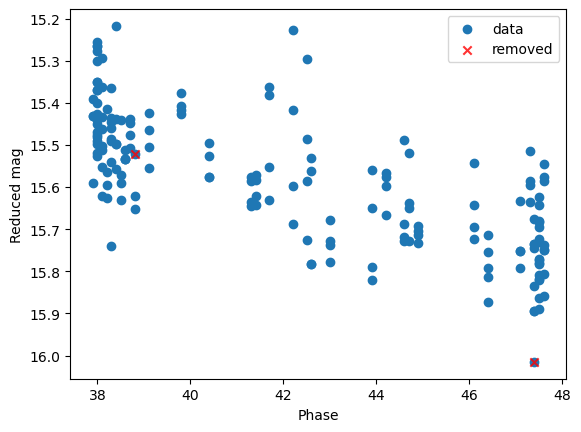

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


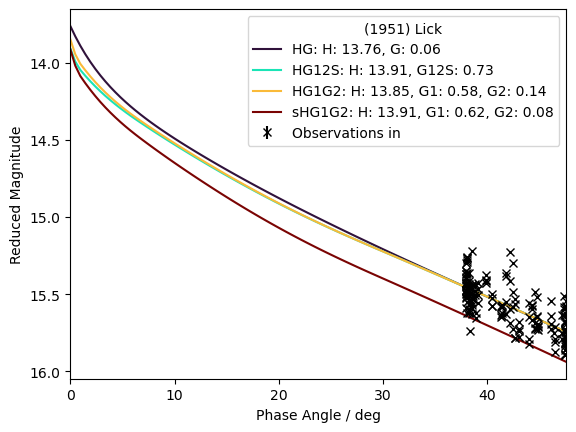

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12656\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


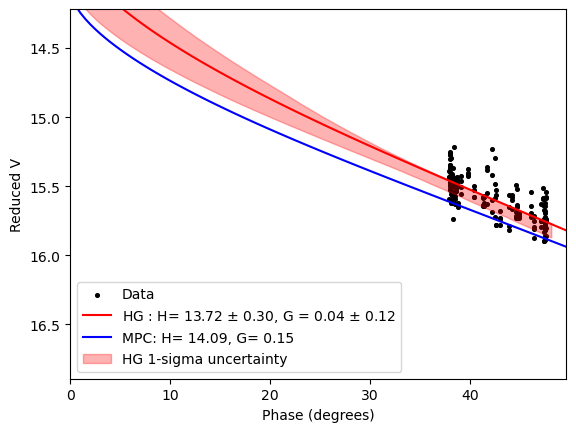

Average displacement HG:  -0.20076065184140202


In [24]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 1951 eksp pu\\"
excel_file = '1951-excelBF.xlsx'
main(path, excel_file, "1951", 14.09, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")


# 1963 W68o

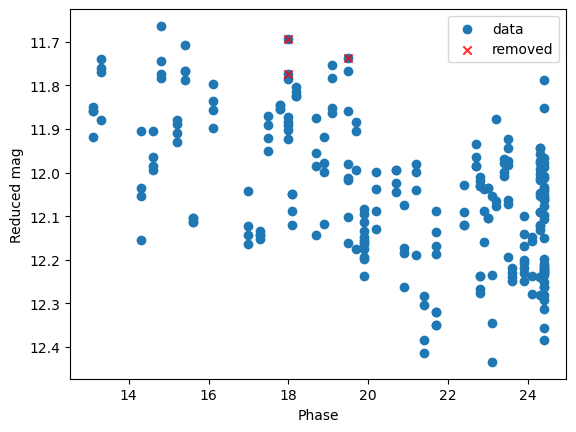

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


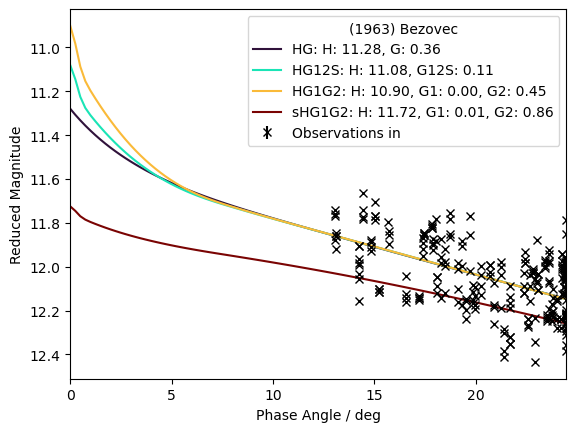

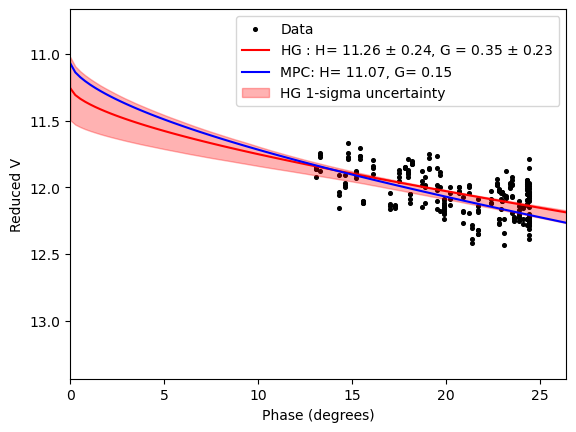

Average displacement HG:  0.006367381271624062


In [32]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 1963 eksp pu\\"
excel_file = '1963-excelBF.xlsx'
main(path, excel_file, "1963", 11.07, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")


# 2128 W68o

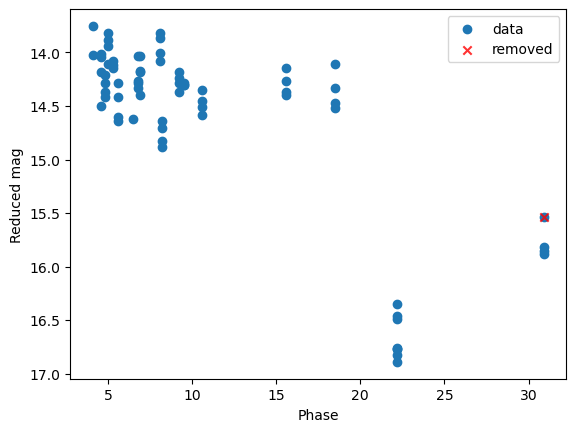

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


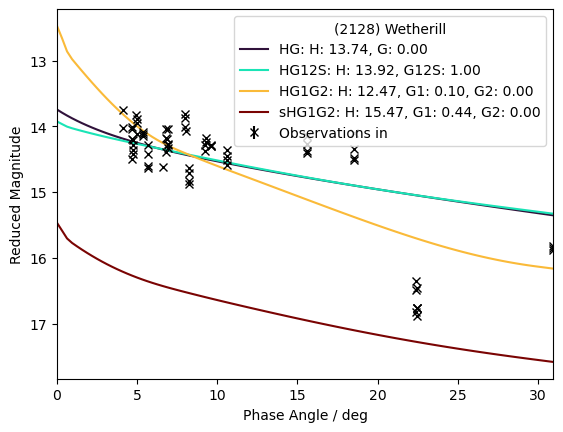

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12656\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


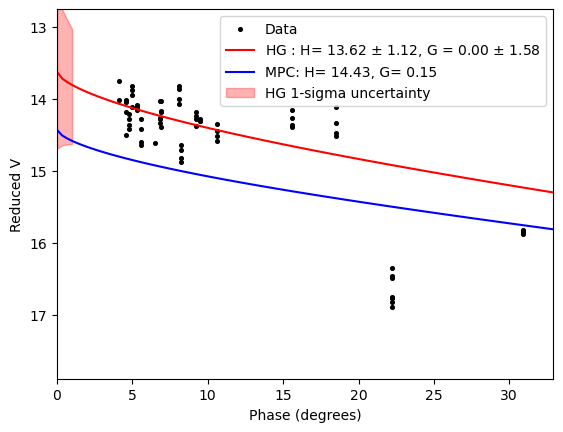

Average displacement HG:  -0.6202898938768442


In [35]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 2128 pu\\"
excel_file = '2128-excelBF.xlsx'
main(path, excel_file, "2128", 14.43, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")


In [37]:
# 2134 W68o

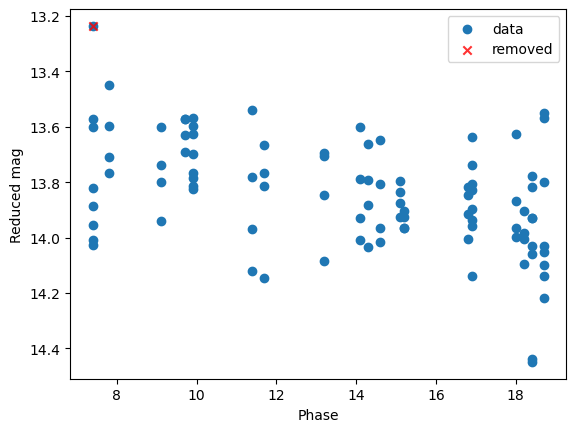

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


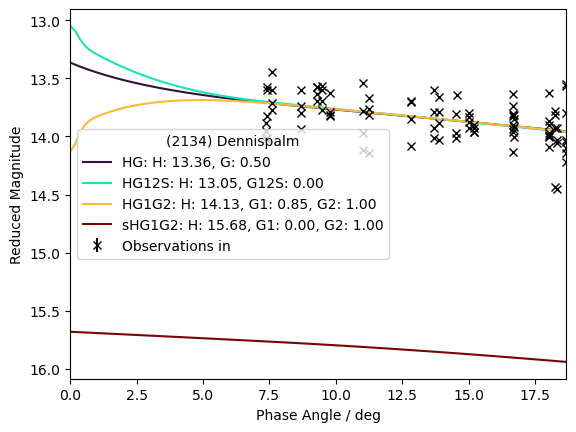

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12656\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


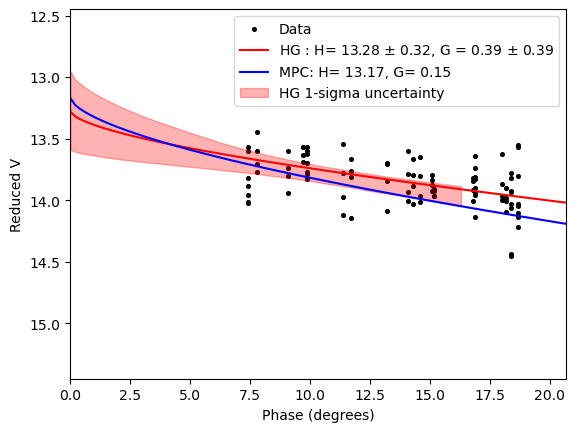

Average displacement HG:  -0.08071632745915291


In [39]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 2134 eksp pu ieguts 4.114\\"
excel_file = '2134-excelBF.xlsx'
main(path, excel_file, "2134", 13.17, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [41]:
# 2150 W68o

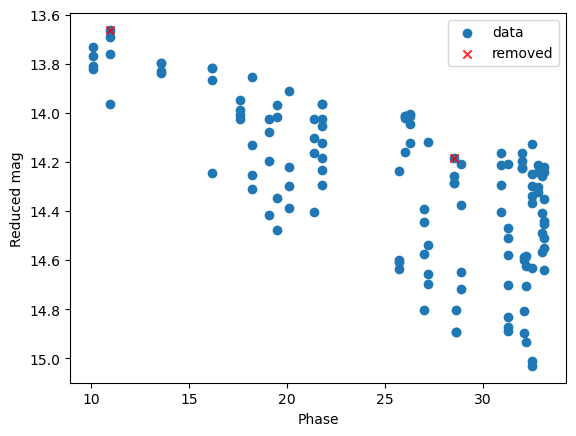

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


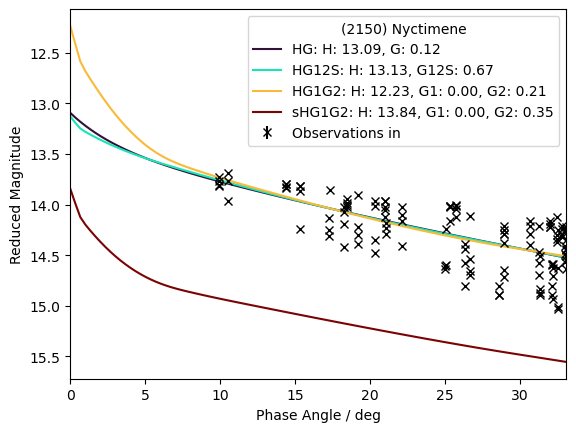

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12656\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


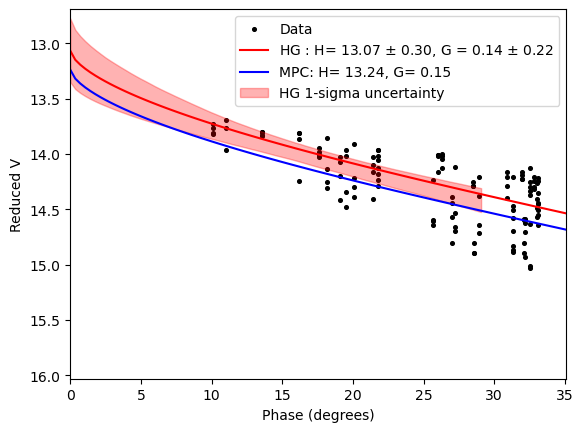

Average displacement HG:  -0.15530284110636483


In [43]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 2150 eksp C57 mans pu\\"
excel_file = '2150-excelBF.xlsx'
main(path, excel_file, "2150", 13.24, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [45]:
# 2174 W68o

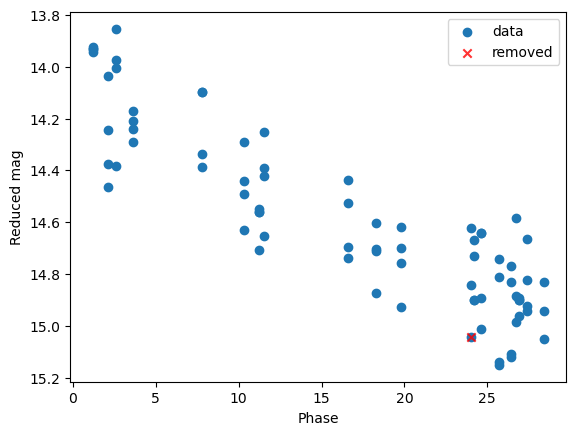

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


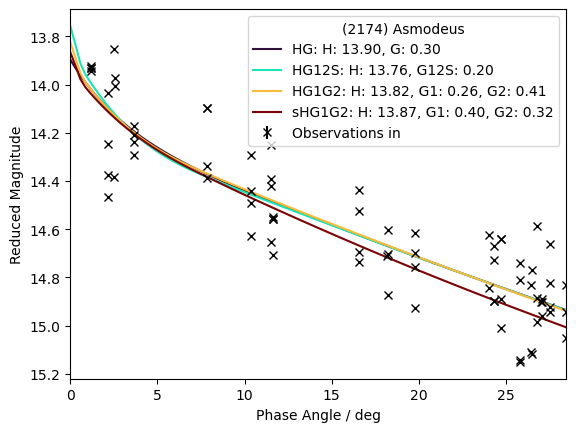

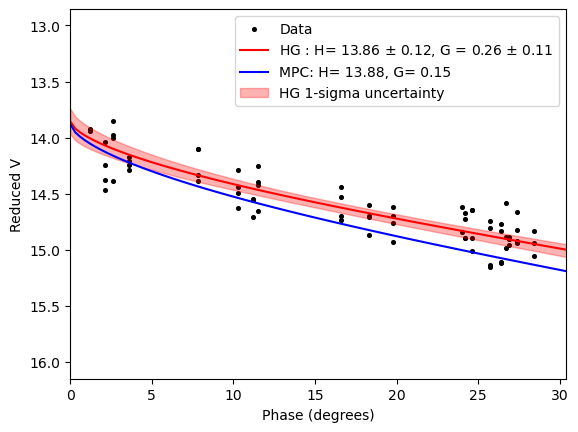

Average displacement HG:  -0.13735477136389296


In [47]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 2174 eksp pu\\"
excel_file = '2174-excelBF.xlsx'
main(path, excel_file, "2174", 13.88, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [49]:
# 2318 W68o

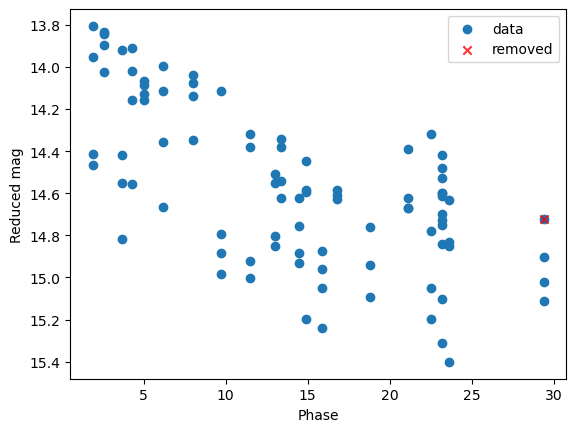

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


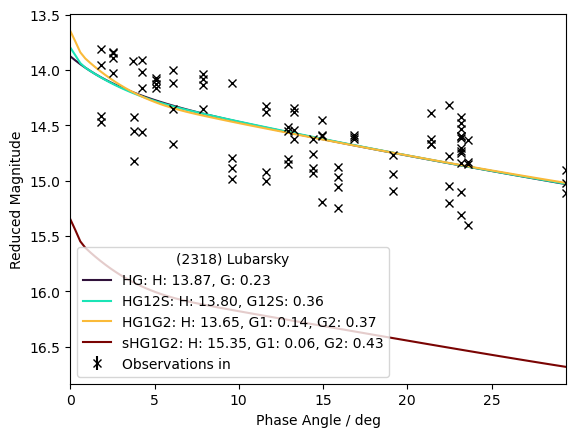

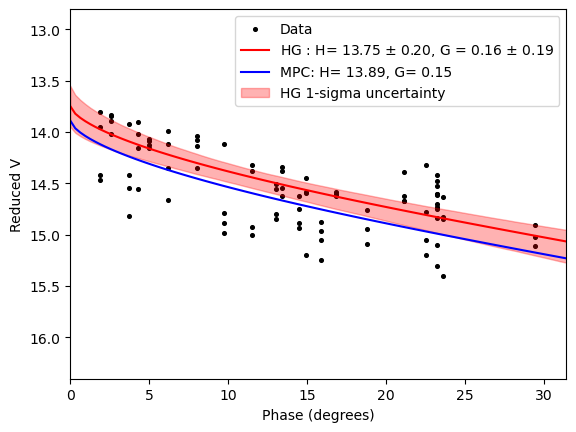

Average displacement HG:  -0.15651874952124434


In [51]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 2318 L C57 pu\\"
excel_file = '2318-excelBF.xlsx'
main(path, excel_file, "2318", 13.89, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [53]:
# 2503 W68o

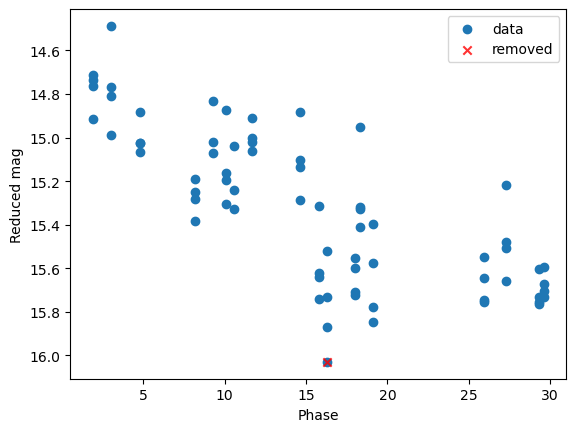

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


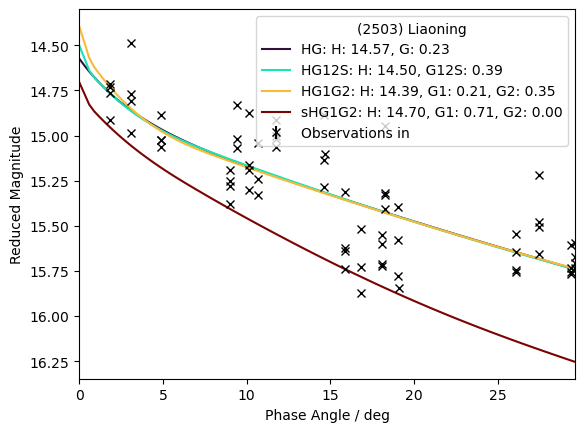

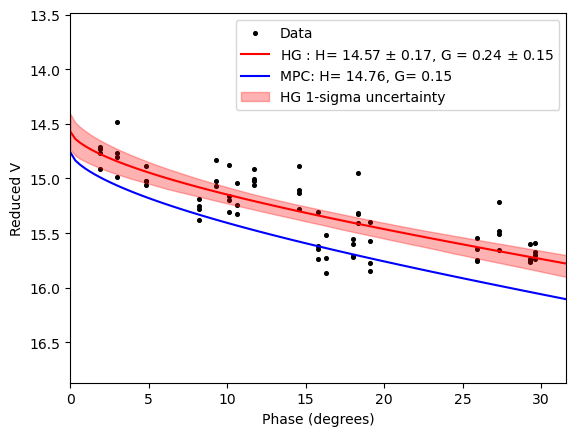

Average displacement HG:  -0.28159885591899325


In [55]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 2503 D pu\\"
excel_file = '2503-excelBF.xlsx'
main(path, excel_file, "2503", 14.76, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [57]:
# 2538 W68o

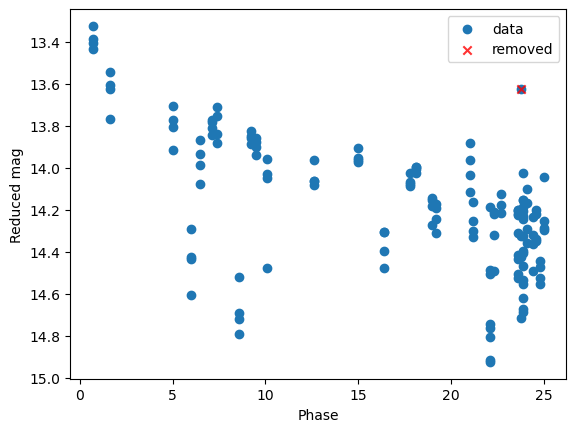

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


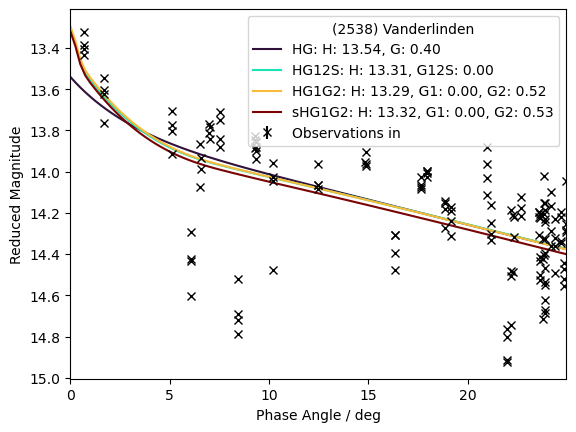

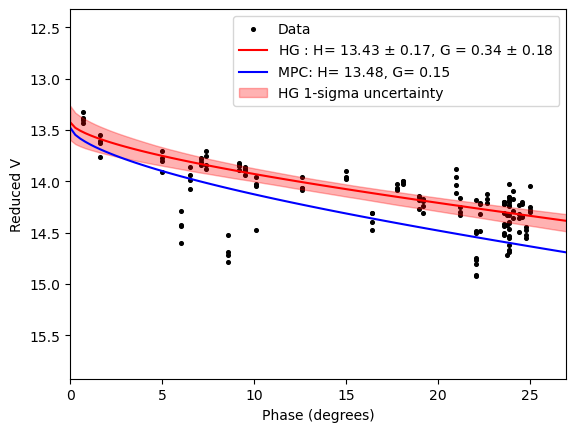

Average displacement HG:  -0.22616030004402177


In [59]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 2538 D pu\\"
excel_file = '2538-excelBF.xlsx'
main(path, excel_file, "2538", 13.48, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [61]:
# 13628 W68o

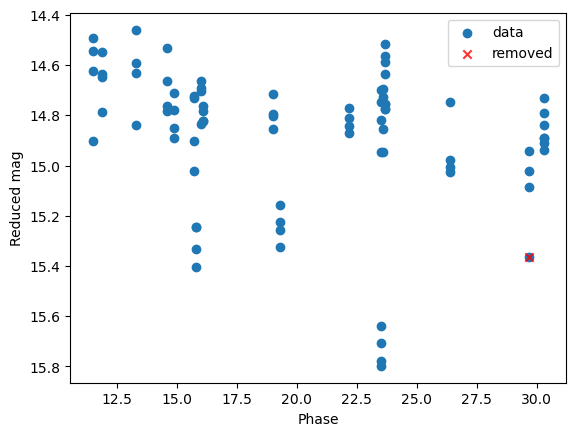

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


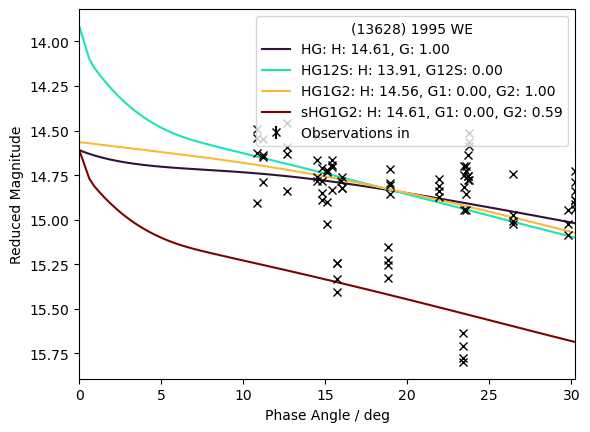

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12656\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


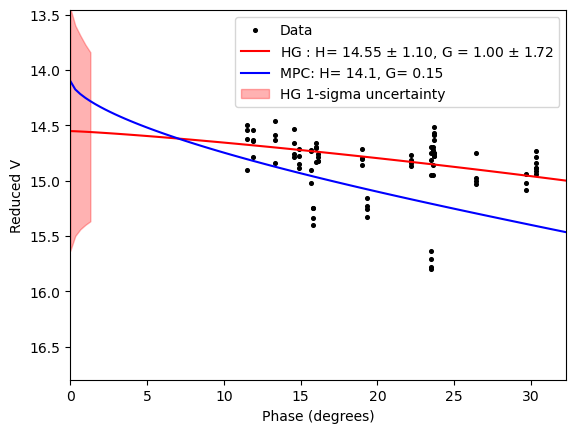

Average displacement HG:  -0.2332203938490176


In [63]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 13628 p\\"
excel_file = '13628-excelBF.xlsx'
main(path, excel_file, "13628", 14.1, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [65]:
# 30512 W68o

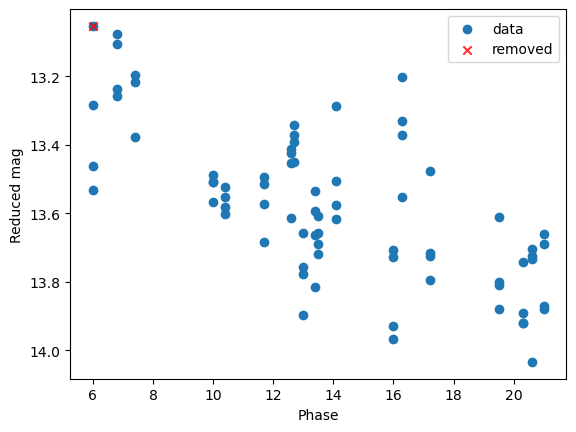

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


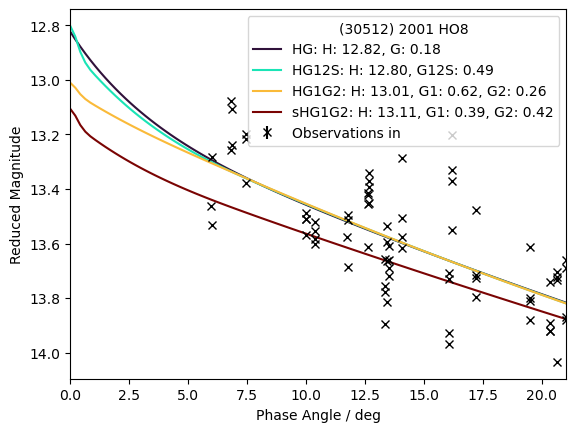

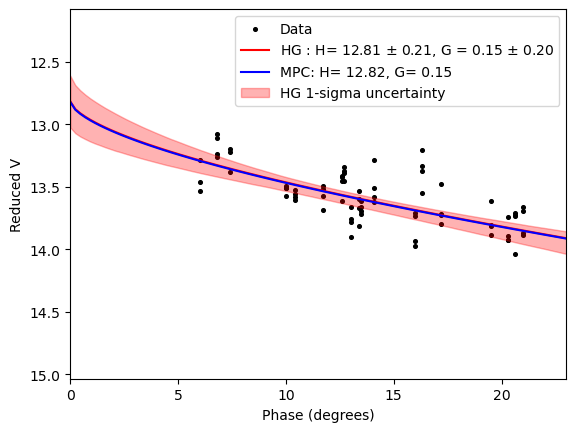

Average displacement HG:  -0.003813057262811448


In [67]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 30512 p ciesams\\"
excel_file = '30512-excelBF.xlsx'
main(path, excel_file, "30512", 12.82, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [69]:
# 2789 T0W6o

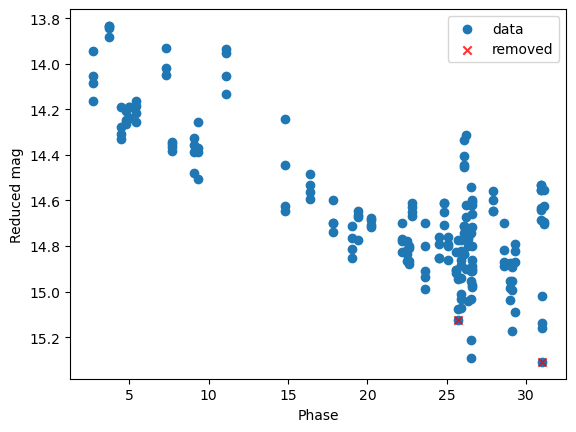

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


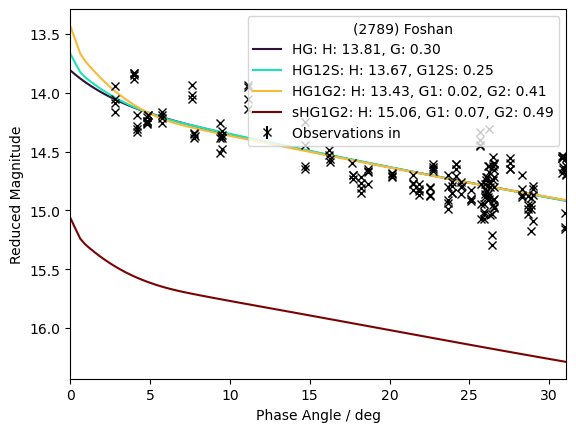

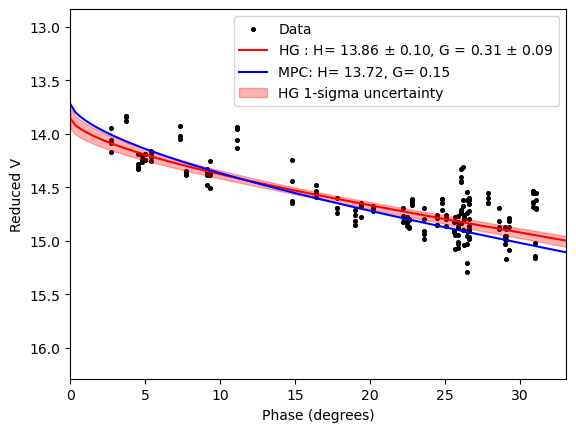

Average displacement HG:  -0.032804924002927116


In [71]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 2789 V labi p\\"
excel_file = '2789-excelBF.xlsx'
main(path, excel_file, "2789", 13.72, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [73]:
# 3173 W68o

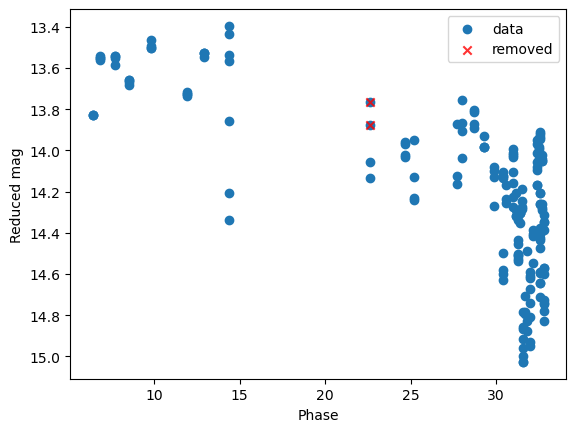

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


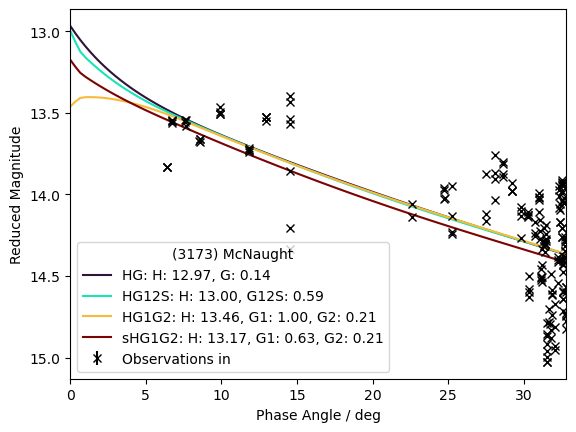

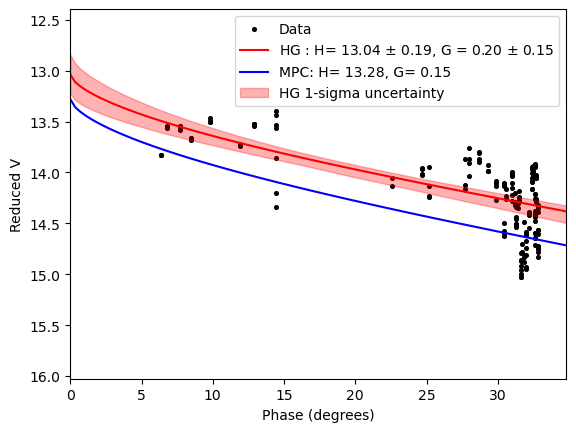

Average displacement HG:  -0.3038107184969805


In [75]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 3173 A C57 pa vidam p\\"
excel_file = '3173-excelBF.xlsx'
main(path, excel_file, "3173", 13.28, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [77]:
# 3392 W680

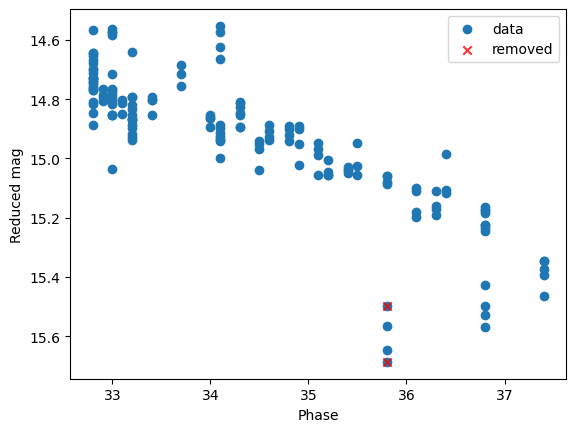

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


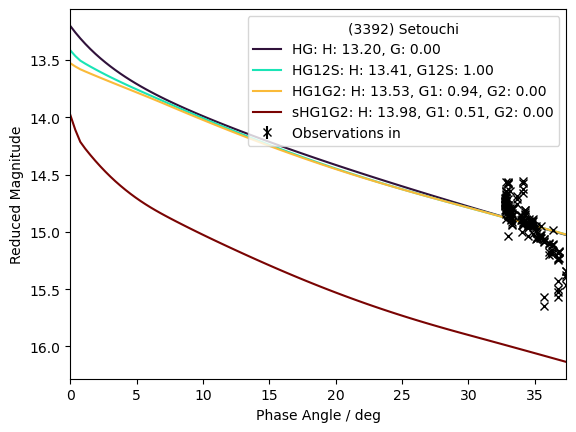

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12656\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


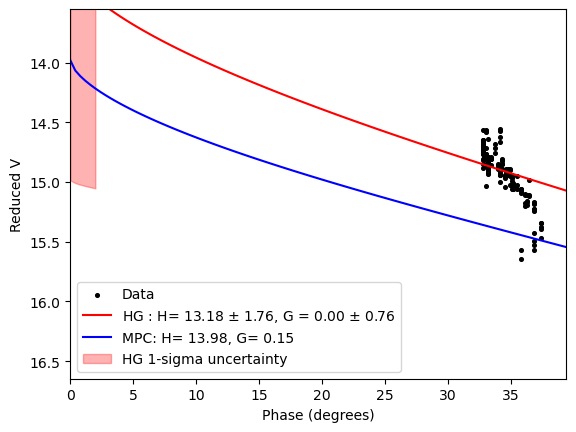

Average displacement HG:  -0.5908516566627329


In [79]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 3392 L labs Ad p\\"
excel_file = '3392-excelBF.xlsx'
main(path, excel_file, "3392", 13.98, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [81]:
# 64577 W680

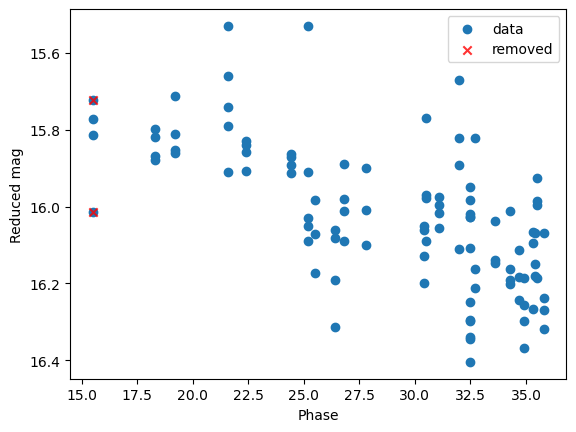

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


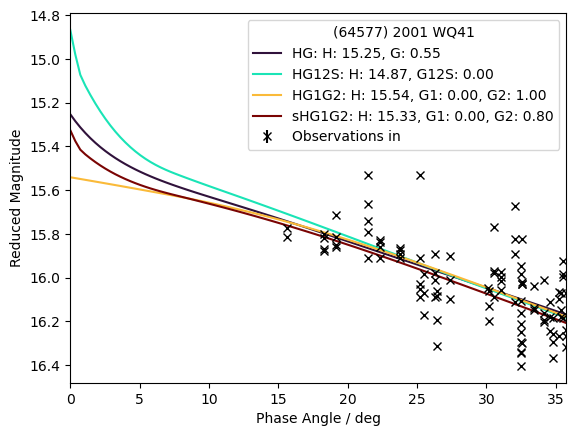

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12656\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


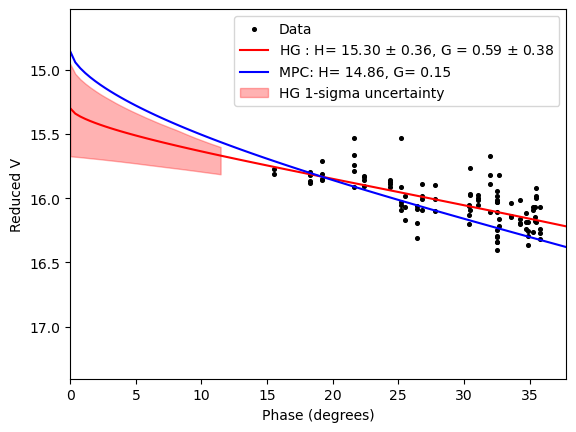

Average displacement HG:  0.0029581131201066313


In [83]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 64577 L nebus\\"
excel_file = '64577-excelBF.xlsx'
main(path, excel_file, "64577", 14.86, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [85]:
# 40256

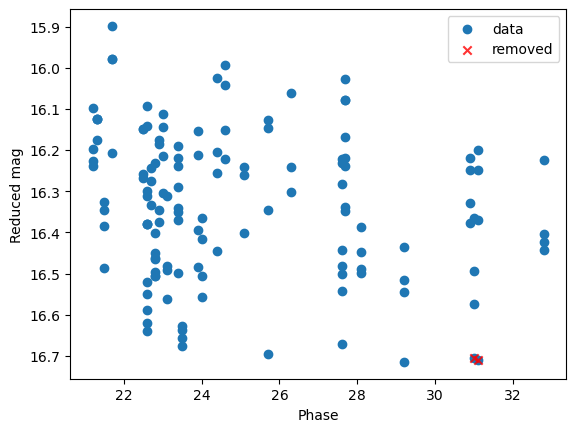

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


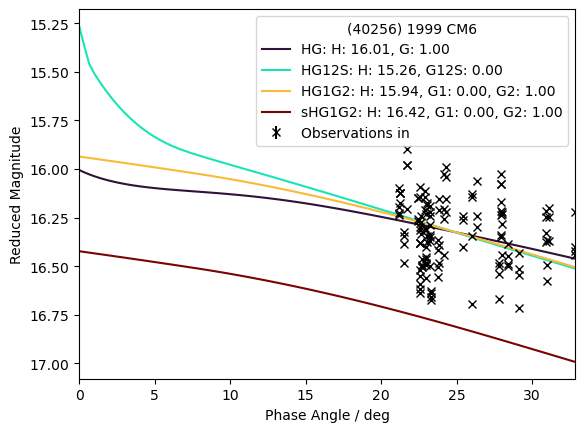

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12656\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


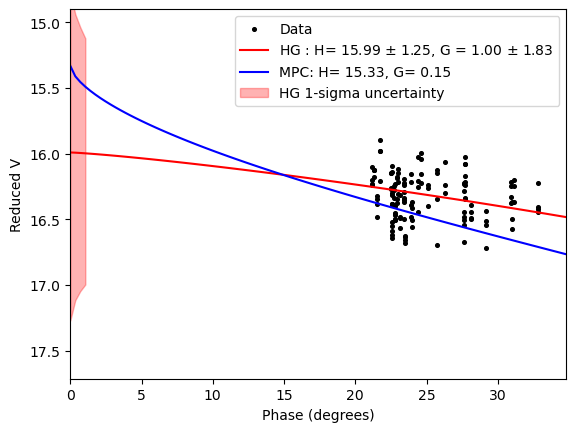

Average displacement HG:  -0.0492034055184245


In [87]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 40256 L P id\\"
excel_file = '40256-excelBF.xlsx'
main(path, excel_file, "40256", 15.33, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [89]:
# 31446

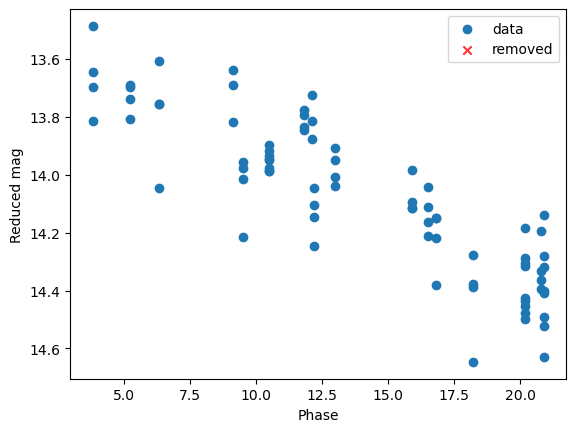

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


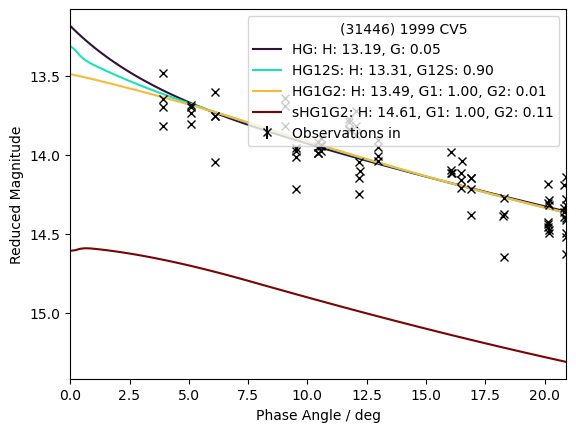

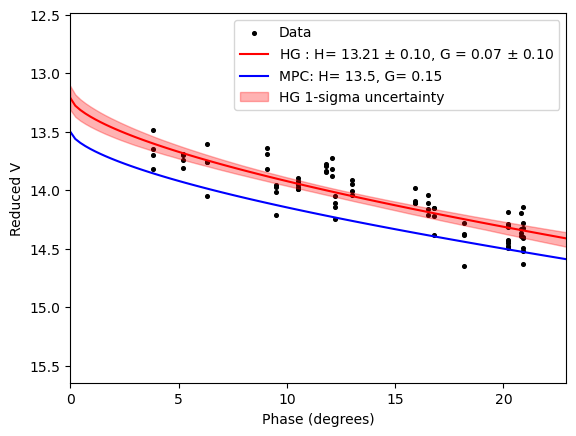

Average displacement HG:  -0.21839466847305555


In [91]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 31446 L Pd\\"
excel_file = '31446-excelBF.xlsx'
main(path, excel_file, "31446", 13.50, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [93]:
# 2971 W68o

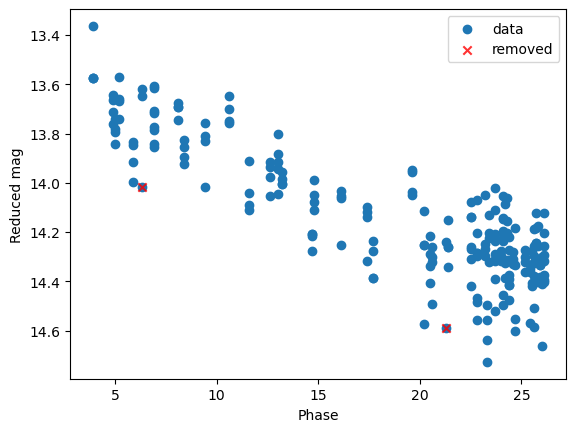

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


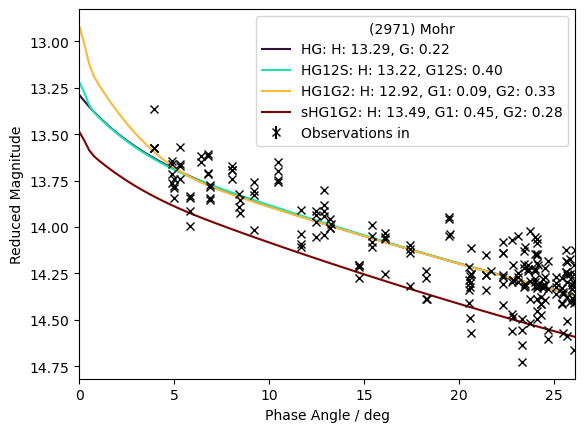

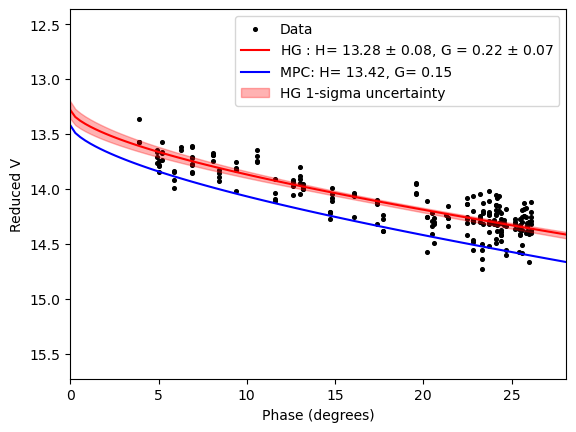

Average displacement HG:  -0.2132443368833039


In [95]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 2971 L C57 labs p\\"
excel_file = '2971-excelBF.xlsx'
main(path, excel_file, "2971", 13.42, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [97]:
# 3172 W68o

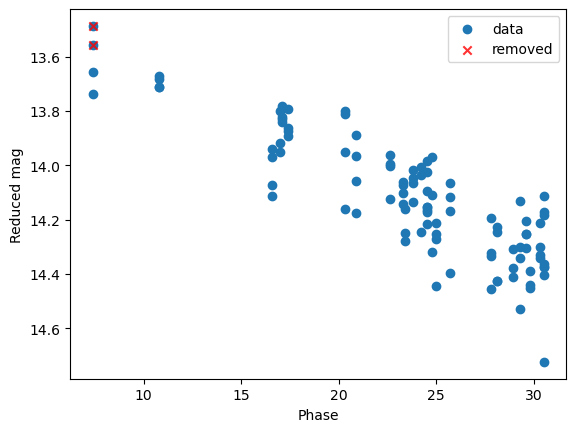

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


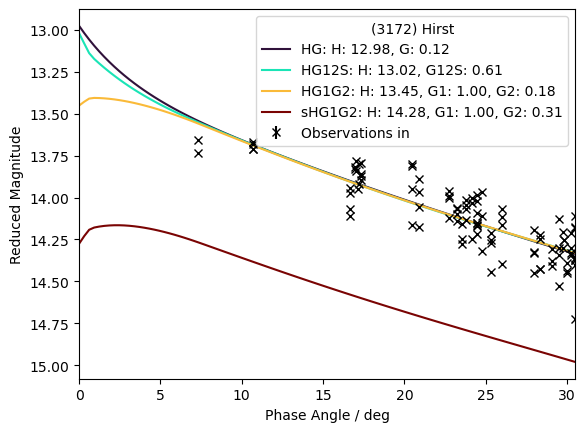

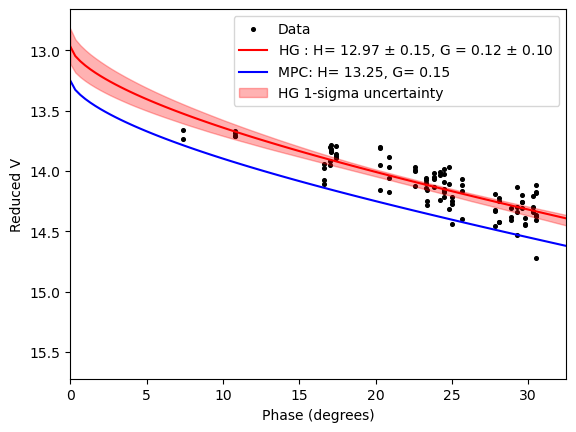

Average displacement HG:  -0.2472826278104936


In [99]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 3172 A labs p\\"
excel_file = '3172-excelBF.xlsx'
main(path, excel_file, "3172", 13.25, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")

In [101]:
# 3185 W68o

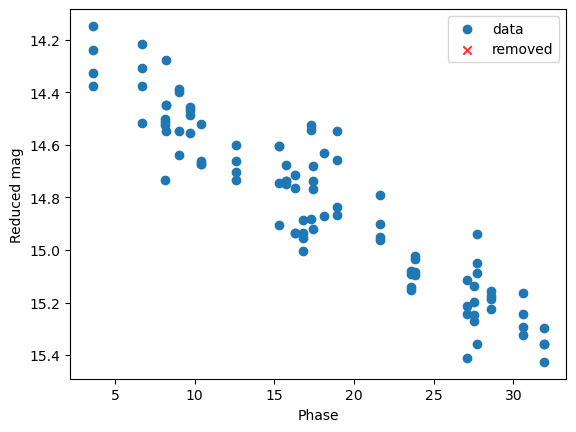

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


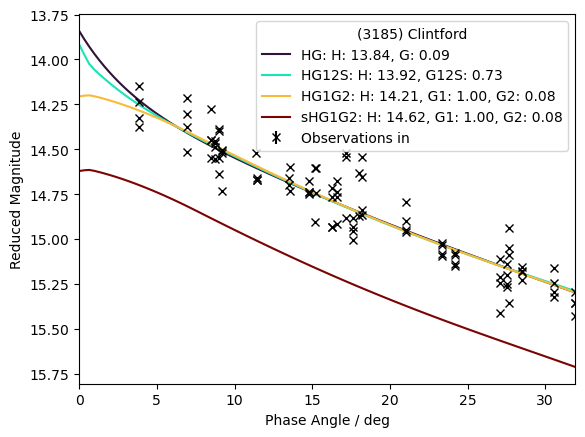

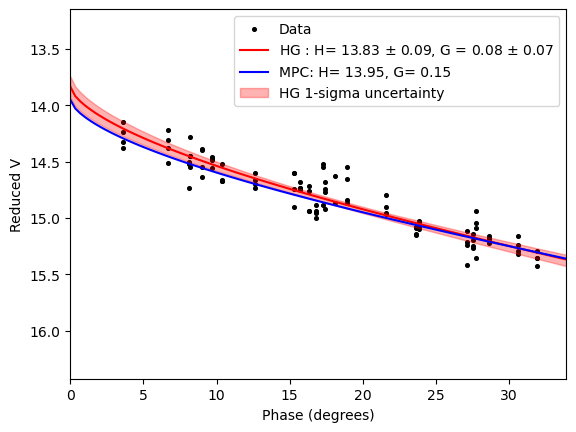

Average displacement HG:  -0.0357175614511549


In [103]:
path = r"H:\Earth MOID asteroīdi 2024.12.20\Ast 3185 L l labs p\\"
excel_file = '3185-excelBF.xlsx'
main(path, excel_file, "3185", 13.95, outlier_removing= False, HG1G2=False, contamination=0.01,sheet_name="W68o")